# Adult Income - Classification Modeling
---
__Date Created:__ 2020-06-20  
__Author:__ Josh Mischung  
__email:__ josh@knoasis.io  

__Dataset:__ [Adult Income, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Adult)

__Comments on Dataset & Objectives:__  
The objective of this notebook is the initial exploration of various classification algorithms that can power a user-facing frontend where inputs are provide by the user and the probability of an outcome is predicted.  

<br>

# Imports & Functions
---

__Imports__

In [1]:
"""
Supress FutureWarnings generated by imblearn using
sklearn method locations that will be deprecated
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# From the usual suspects
from collections import Counter
from numpy import unique
from numpy import mean
from numpy import std
from pandas import read_pickle
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from category_encoders.woe import WOEEncoder
from imblearn.over_sampling import SMOTENC

# Pipeline
from sklearn.pipeline import Pipeline

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

# Config
from sklearn import set_config
set_config(display='diagram')

Using TensorFlow backend.


__Functions__

In [3]:
# Evaluate model
def evaluate_model(X, y, model):
    """
    *Reference sklearn.metrics.SCORERS.keys() for list of available scorers*
    """
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=143)
    # Evaluate model
    scores = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=4)
    return scores

# Split & smote resample data
def split_resample(feature_df, target):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size=0.1, stratify=y, random_state=142)

    # Obtain catigorical column indicies
    cat_feats = feature_df.select_dtypes('category').columns.tolist()
    cat_index = [feature_df.columns.get_loc(col) for col in cat_feats]
    
    # Resample with smote
    smt = SMOTENC(random_state=143, categorical_features=cat_index)
    X_train, y_train = smt.fit_sample(X_train, y_train)
    
    # Revert to pandas objects
    X_train = DataFrame(X_train, columns=feature_df.columns)
    y_train = Series(y_train, name=target.name)
    
    # Revert to original dtype
    X_train[X_train.loc[:, cat_feats].columns] = X_train.loc[:, cat_feats].apply(lambda x: x.astype('category'))
    X_train[X_train.select_dtypes(['object']).columns] = X_train.select_dtypes(['object'])\
                                                                .apply(lambda x: x.astype('int64'))
    
    # Print target category counts
    title = "Resampled Target Category Counts"
    counts = unique(y_train, return_counts=True)
    print(f"{title}\n{'-' * len(title)}")
    print(f"{counts[0][0]}: {counts[1][0]}\n{counts[0][1]}: {counts[1][1]}")
    
    return X_train, X_test, y_train, y_test

# Models dictionary
def get_models():
    models_dict = {
        'LogReg': LogisticRegression(max_iter=10000, n_jobs=-1),
        'SGD': SGDClassifier(max_iter=10000, tol=1e-3, n_jobs=-1),
        'Perceptron': Perceptron(max_iter=10000, tol=1e-3, n_jobs=-1),
        'PassiveAgressive': PassiveAggressiveClassifier(max_iter=10000, tol=1e-3, n_jobs=-1),
        'CART': DecisionTreeClassifier(),
        'BAG': BaggingClassifier(n_estimators=100, n_jobs=-1),
        'RF': RandomForestClassifier(n_estimators=100, n_jobs=-1),
        'GBM': GradientBoostingClassifier(n_estimators=100)
    }
    
    return models_dict

<br>  
# Load Data
---

In [4]:
# Load data
data = 'adult_df_postEDA.pkl'
adult_df = read_pickle(data)
adult_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,workclass_null,occupation_null,native_country_null,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,0,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0,0,0


In [5]:
# Metadata
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 18 columns):
age                    32561 non-null int64
workclass              32561 non-null category
fnlwgt                 32561 non-null int64
education              32561 non-null category
education_num          32561 non-null int64
marital_status         32561 non-null category
occupation             32561 non-null category
relationship           32561 non-null category
race                   32561 non-null category
sex                    32561 non-null category
capital_gain           32561 non-null int64
capital_loss           32561 non-null int64
hours_per_week         32561 non-null int64
native_country         32561 non-null category
workclass_null         32561 non-null int64
occupation_null        32561 non-null int64
native_country_null    32561 non-null int64
income                 32561 non-null category
dtypes: category(9), int64(9)
memory usage: 2.5 MB


<br>  
# Generate Baseline & Process Data
---

__Generate Baseline__

In [6]:
# Separate features, target
X = adult_df.iloc[:, :-1]
y = adult_df.iloc[:, -1]

# Instantiate baseline model
model_dummy = DummyClassifier(strategy="most_frequent")

# Evaluate model performance
scores = evaluate_model(X, y, model_dummy)
model = "Baseline Model (Most Frequent)"
print(f"{model}\n{'-' * len(model)}")
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
print('Mean ROC-AUC: %.3f (%.3f)' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

Baseline Model (Most Frequent)
------------------------------
Mean Accuracy: 0.759 (0.000)
Mean ROC-AUC: 0.500 (0.000)


__Process Data__

In [7]:
# Split data
X_train, X_test, y_train, y_test = split_resample(X, y)

# Convert categories to numeric
woe = WOEEncoder(regularization=1e-8, random_state=143)
X_train[X_train.select_dtypes('category').columns] = woe.fit_transform(X_train.select_dtypes('category'), y_train)

Resampled Target Category Counts
--------------------------------
0: 22247
1: 22247


<br>  
# Evaluate Algorithms
---
To this point little feature engineering or selection work has been performed. The purpose of testing various algorithms at this point is to narrow efforts to 2-3 algorithms by spot checking the base performance of each on this dataset, then focus optimization efforts on those few algorithms by performing feature selection/engineering and hyperparameter tuning.

__Evaluate Models__

In [8]:
# Define models
models = get_models()

# Evaluate models
results = {}

for k, v in models.items():
    # Build pipeline
    clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', v)
    ])
    
    # Evaluate model
    scores = evaluate_model(X_train, y_train, clf)
    results[k] = scores
    name = k
    print(f"{name}\n{'-' * len(name)}")
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
    print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
    print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

LogReg
------
Mean Accuracy: 0.868 (0.004)
Mean F1: 0.872 (0.004)
Mean ROC-AUC: 0.941 (0.003)

SGD
---
Mean Accuracy: 0.830 (0.031)
Mean F1: 0.828 (0.041)
Mean ROC-AUC: 0.858 (0.063)

Perceptron
----------
Mean Accuracy: 0.834 (0.027)
Mean F1: 0.833 (0.042)
Mean ROC-AUC: 0.881 (0.041)

PassiveAgressive
----------------
Mean Accuracy: 0.794 (0.057)
Mean F1: 0.792 (0.074)
Mean ROC-AUC: 0.868 (0.060)

CART
----
Mean Accuracy: 0.859 (0.004)
Mean F1: 0.860 (0.005)
Mean ROC-AUC: 0.859 (0.004)

BAG
---
Mean Accuracy: 0.896 (0.004)
Mean F1: 0.895 (0.004)
Mean ROC-AUC: 0.963 (0.002)

RF
--
Mean Accuracy: 0.897 (0.004)
Mean F1: 0.896 (0.004)
Mean ROC-AUC: 0.964 (0.002)

GBM
---
Mean Accuracy: 0.896 (0.004)
Mean F1: 0.896 (0.004)
Mean ROC-AUC: 0.965 (0.002)



__Plot F1 & ROC-AUC Results__

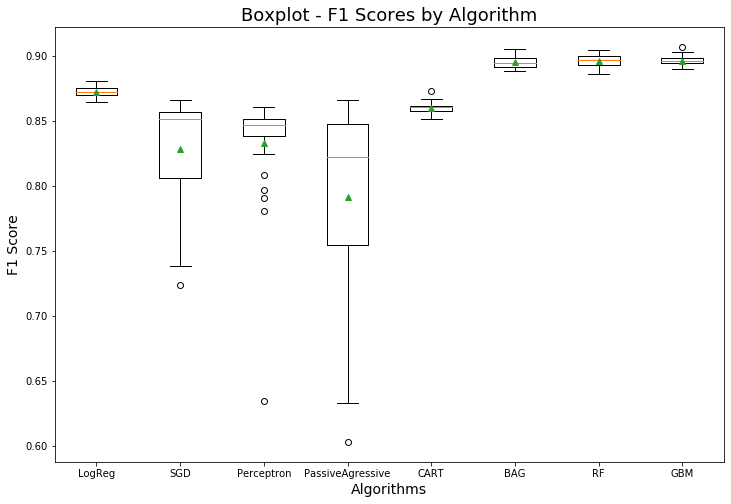

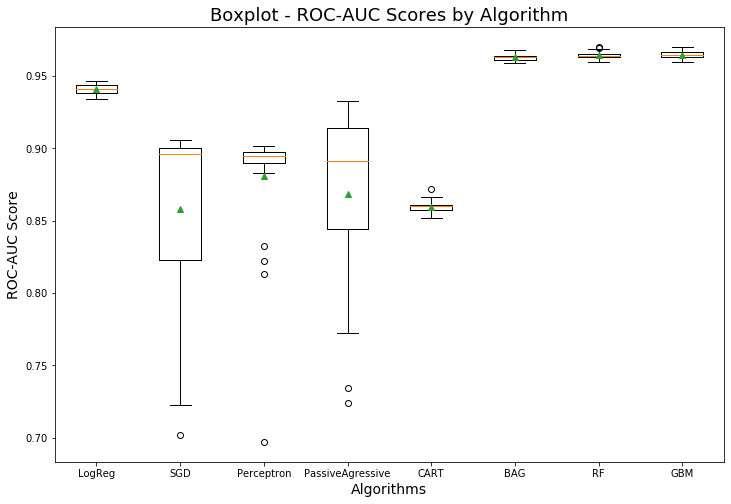

In [12]:
# Prepare plot inputs
names = []
f1 = []
roc_auc = []

for k, v in results.items():
    names.append(k)
    f1.append(v['test_f1'])
    roc_auc.append(v['test_roc_auc'])
    
# F1 scores    
fig = plt.figure(figsize=(12, 8))
plt.boxplot(f1, labels=names, showmeans=True)
plt.title("Boxplot - F1 Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
print("")
plt.show();

# ROC-AUC scores
fig = plt.figure(figsize=(12, 8))
plt.boxplot(roc_auc, labels=names, showmeans=True)
plt.title("Boxplot - ROC-AUC Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
print("" * 2)
plt.show();